In [1]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.datasets import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.linear_model import *
from sklearn.inspection import *
from sklearn.metrics import *
from sklearn.metrics import auc #почему-то если отдельно не импортировать, не видит его
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.svm import SVC

# Загрузка данных и ознакомление

In [2]:
df = pd.read_excel('Данные_курсовая.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Code            1343 non-null   object 
 1   Name            1343 non-null   object 
 2   Brand           1343 non-null   object 
 3   IncomeCenter    1343 non-null   object 
 4   Article         1343 non-null   object 
 5   IFCG            1343 non-null   int64  
 6   ItemType        1343 non-null   object 
 7   ItemStatus      1343 non-null   object 
 8   Fabric          1343 non-null   object 
 9   InsuranceDays   1343 non-null   int64  
 10  LogLevDays      1343 non-null   int64  
 11  ItemLine        1343 non-null   object 
 12  HasTester       1343 non-null   int64  
 13  MinBatch        1343 non-null   int64  
 14  Provider        1343 non-null   object 
 15  Country         1343 non-null   object 
 16  ItemCategory    1343 non-null   object 
 17  ABC Brand       1343 non-null   o

# Предобработка данных

In [4]:
#Article дублирует Code
df = df.drop(columns=["Article"])

In [5]:
#заполнение пропусков медианой по группам ItemCategory и Country
df["TurnoverRub"] = df.groupby(["ItemCategory", "Country"])["TurnoverRub"].transform(
    lambda x: x.fillna(x.median()))

df["TurnoverAmount"] = df.groupby(["ItemCategory", "Country"])["TurnoverAmount"].transform(
    lambda x: x.fillna(x.median()))

In [6]:
#удалим оставшиеся 4 пропуска
df = df.dropna(subset=['TurnoverRub', 'TurnoverAmount']).reset_index(drop=True)

In [7]:
#ТНВЭД - категориальная переменная
df["IFCG"] = df["IFCG"].astype("object")

In [8]:
df[df.duplicated()]

,Code,Name,Brand,IncomeCenter,IFCG,ItemType,ItemStatus,Fabric,InsuranceDays,LogLevDays,ItemLine,HasTester,MinBatch,Provider,Country,ItemCategory,ABC Brand,TurnoverRub,TurnoverAmount


In [9]:
df[df.duplicated(subset="Code")]

,Code,Name,Brand,IncomeCenter,IFCG,ItemType,ItemStatus,Fabric,InsuranceDays,LogLevDays,ItemLine,HasTester,MinBatch,Provider,Country,ItemCategory,ABC Brand,TurnoverRub,TurnoverAmount


# Кодирование целевой переменной

In [10]:
df["ABC Brand"].unique()

array(['C', 'D', 'A', 'B', 'AA'], dtype=object)

In [11]:
df['ItemImportance'] = df['ABC Brand'].apply(lambda x: 1 if x in ['A', 'AA'] else 0)

# Анализ выбросов

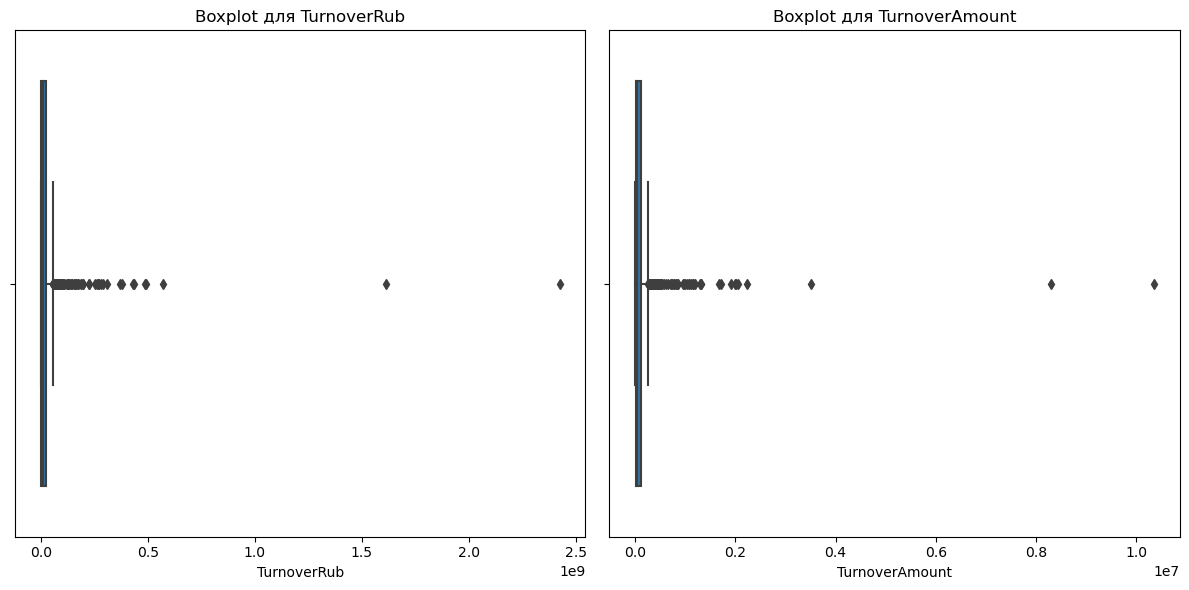

In [12]:
#все данные в датасете важны,но можем посмотреть выбросы по обороту в рублях и штуках
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='TurnoverRub')
plt.title('Boxplot для TurnoverRub')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='TurnoverAmount')
plt.title('Boxplot для TurnoverAmount')

plt.tight_layout()
plt.show()

In [13]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers_turnover_rub = find_outliers(df, 'TurnoverRub')
outliers_turnover_amount = find_outliers(df, 'TurnoverAmount')

all_outliers = pd.concat([outliers_turnover_rub, outliers_turnover_amount]).drop_duplicates()
top_outliers = all_outliers.nlargest(5, 'TurnoverRub')

top_outliers[['Name', 'TurnoverRub', 'TurnoverAmount']]

,Name,TurnoverRub,TurnoverAmount
95,Vivienne Sabo Тушь для ресниц Cabaret premiere...,2.422781e+09,10359413.0
94,Vivienne Sabo Тушь для ресниц Cabaret со сцени...,1.614586e+09,8298449.0
98,Vivienne Sabo Тушь д/ресниц Cabaret premiere с...,5.691229e+08,2222033.0
74,Vivienne Sabo Тушь для ресниц влагостойкая/Wat...,4.918478e+08,2011481.0
166,Vivienne Sabo Карандаш для бровей автоматическ...,4.872467e+08,2043352.0


Ну тут все понятно, тушь кабарет...даже добавить нечего, комментарии излишни. Уберем их из классификации.

In [14]:
df = df.drop(all_outliers.index)

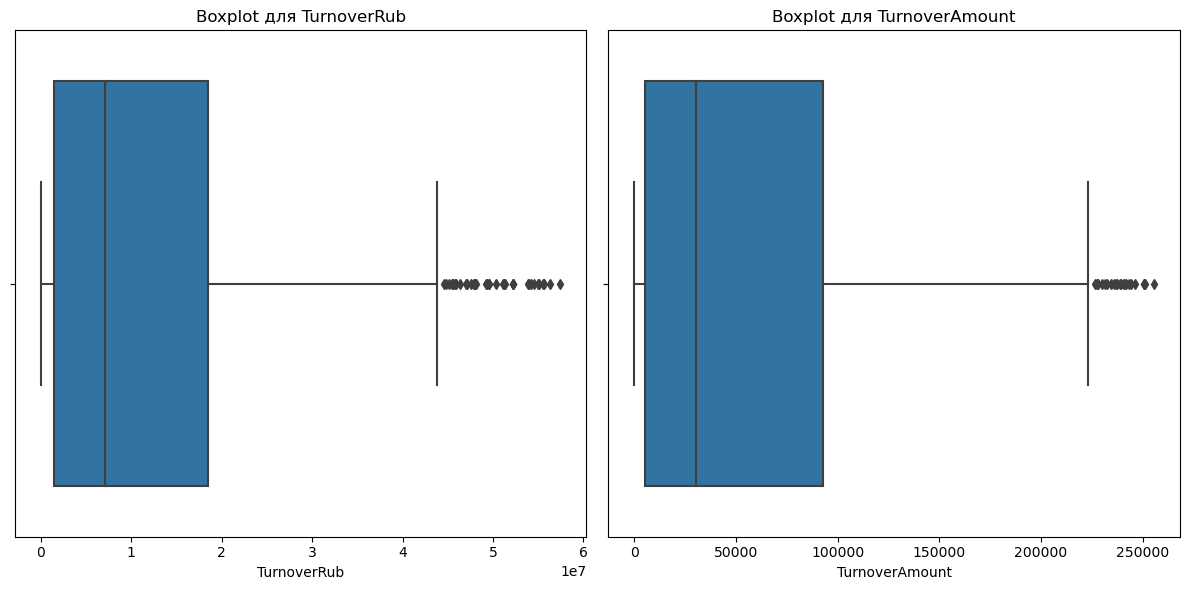

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='TurnoverRub')
plt.title('Boxplot для TurnoverRub')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='TurnoverAmount')
plt.title('Boxplot для TurnoverAmount')

plt.tight_layout()
plt.show()

# Анализ переменных

Код и название не будем брать как пременные, все остальное - берем и делим.

In [16]:
numeric_features = ['InsuranceDays', 'LogLevDays', 'MinBatch', 'TurnoverRub', 'TurnoverAmount']
categorical_features = ['Brand', 'IncomeCenter', 'IFCG', 'ItemType', 'ItemStatus',  'Fabric', 'ItemLine', 
    'Provider', 'Country', 'ItemCategory', 'ABC Brand', 'HasTester']

На этом моменте проверим корреляцию числовых признаков с результатом:

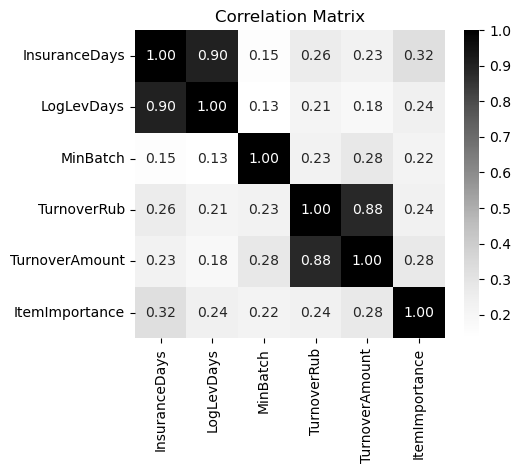

In [17]:
correlation_data = df[numeric_features + ['ItemImportance']]
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="Greys", fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()

Исключим влияющие друг на друга признаки, которые имеют схожий смысл - это InsuranceDays (признак, зависящий от LogLevDays) и TurnoverAmount (зависящий от TurnoverRub)

Помимо всего прочего, мною было принято решение исключить из анализа булеан - переменную: наличие тестера, которая мне не нравится с имперической точки зрения. Наличие тестера влияет на тип косметики, но не на ее приоритетность для компании (однако расчетный способ изучения влияния может дать иной результат). Ну и конечно, сама пременная ABC Brand также должна быть исключена

In [18]:
numeric_features = ['LogLevDays', 'MinBatch', 'TurnoverRub']
categorical_features = ['Brand', 'IncomeCenter', 'IFCG', 'ItemType', 'ItemStatus',  'Fabric', 'ItemLine', 
    'Provider', 'Country', 'ItemCategory']

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

In [20]:
X = df.drop(columns=['ItemImportance', 'Code', 'Name', 'InsuranceDays', 'HasTester', 'ABC Brand', 'TurnoverAmount' ])
X_transformed = preprocessor.fit_transform(X)

y = df['ItemImportance']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Found unknown categories in columns [2, 5, 6, 7, 9] during transform. These unknown categories will be encoded as all zeros


Все, что не попало в тестовую из параметров, просто заполнили нулями.

# Отбор признаков

## Lasso

In [23]:
lasso = LassoCV(cv=5, random_state=42).fit(X_train_transformed, y_train)
lasso_selector = SelectFromModel(lasso, prefit=True)
X_train_lasso = lasso_selector.transform(X_train_transformed)
X_test_lasso = lasso_selector.transform(X_test_transformed)

selected_features_lasso = np.array([f"Lasso {i}" for i in range(X_train_lasso.shape[1])])

## Shap

In [24]:
model_shap = LogisticRegression(random_state=42).fit(X_train_transformed, y_train)
explainer = shap.LinearExplainer(model_shap, X_train_transformed)
shap_values = explainer.shap_values(X_train_transformed)

shap_importances = np.abs(shap_values).mean(axis=0)
top_shap_features = np.argsort(shap_importances)[-X_train_transformed.shape[1]:]
X_train_shap = X_train_transformed[:, top_shap_features]
X_test_shap = X_test_transformed[:, top_shap_features]

selected_features_shap = np.array([f"SHAP {i}" for i in range(X_train_shap.shape[1])])

## Поиск лучшего способа отбора

In [25]:
#функция для консолидации метрик по моделям и методам обора
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    acc = accuracy_score(y_test, y_pred)
    return auc, acc

In [26]:
#соберем метрики по 2м моделям и 2м способам отбора
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = []

for method, (X_train_sel, X_test_sel, selected_features) in zip(
    ["Lasso", "SHAP"],
    [(X_train_lasso, X_test_lasso, selected_features_lasso), 
     (X_train_shap, X_test_shap, selected_features_shap)]
):
    for model_name, model in models.items():
        auc, acc = train_and_evaluate(model, X_train_sel, y_train, X_test_sel, y_test)
        results.append({"Feature Selection": method, "Model": model_name, "ROC_AUC": auc, "Accuracy": acc})

In [27]:
#посмотрим на полученное сравнение
results_df = pd.DataFrame(results)
pivot_table = results_df.pivot(index="Feature Selection", columns="Model", values=["ROC_AUC", "Accuracy"])
print(pivot_table)

                              ROC_AUC                      Accuracy          
Model             Logistic Regression       SVM Logistic Regression       SVM
Feature Selection                                                            
Lasso                        0.969010  0.970021            0.894472  0.889447
SHAP                         0.970486  0.970459            0.907035  0.891960


Будем пробовать обучать модели лог. регрессии и опорных векторов на переменных, отобранных по шепли.

# Шепли, еще раз отбираем

In [28]:
explainer = shap.LinearExplainer(model_shap, X_train_transformed)
shap_values = explainer.shap_values(X_train_transformed)
shap_importances = np.abs(shap_values).mean(axis=0)

#отберем по порогу значимости
threshold = 0.01
top_features_indices = np.where(shap_importances > threshold)[0]

X_train_selected = X_train_transformed[:, top_features_indices]
X_test_selected = X_test_transformed[:, top_features_indices]

In [29]:
num_features = numeric_features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([num_features, cat_features])

In [32]:
len(all_features)

444

In [30]:
selected_feature_names = all_features[top_features_indices]
print("Отобранные признаки для модели:")
for feature in selected_feature_names:
    print(feature)

Отобранные признаки для модели:
LogLevDays
MinBatch
TurnoverRub
Brand_Influence
Brand_Love Generation
Brand_STELLARY SKIN STUDIO
Brand_Stellary
Brand_Stellary Лак
Brand_Vivienne Sabo
IncomeCenter_Influence
IncomeCenter_Love Gen
IncomeCenter_Stellary
IncomeCenter_Stellary Skin Studio
IncomeCenter_Вивьен Сабо
IFCG_3304200000
IFCG_3304300000
IFCG_3304910000
IFCG_3304990000
ItemType_Спецификация
ItemStatus_Исключенный
ItemStatus_Коллекция
ItemStatus_Не закупается
ItemStatus_Новинка
Fabric_Ancorotti Cosmetics S.P.A.
Fabric_GUANG DONG 3 INS TECHNOLOGY CO.,LTD
Fabric_Guangdong Bawei Biotechnology Corporation
Fabric_LuxCos S.A.
Fabric_Ningbo Eyecos Cosmetic Co., Ltd
Fabric_ZHEJIANG CHEERFLOR COSMETICS CO., LTD
Fabric_ZHEJIANG MEEUE COSMETICS CO., LTD
Fabric_ZHOGSHAN FULIN COSMETICS CO., LTD
Fabric_Zhejiang Diefei Cosmetic Co., Ltd
Fabric_Zhejiang J and C Cosmetics Co.,Ltd
Fabric_Zhongshan Fulin Cosmetics Co., Ltd
Fabric_ООО "Гамма Косметик"
Fabric_ООО "Октопас"
ItemLine_ACNE FIGHTER
ItemLine_A

# Поиск лучших параметров для модели лог.регрессии

In [31]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_selected, y_train)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC после GridSearchCV: {roc_auc}")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


ROC AUC после GridSearchCV: 0.9633502843394576


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


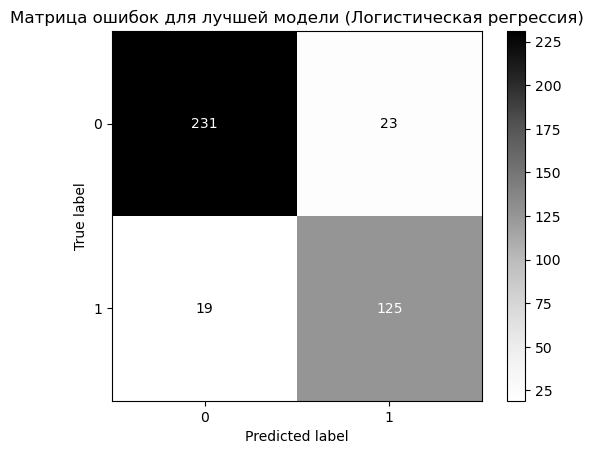

In [32]:
y_pred = best_model.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Greys', values_format='d')
plt.title("Матрица ошибок для лучшей модели (Логистическая регрессия)")
plt.show()

# Поиск лучших параметров для опорных векторов

In [33]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_train_selected, y_train)

best_params_svm = grid_search_svm.best_params_
print("Лучшие параметры для SVM:", best_params_svm)

best_model_svm = grid_search_svm.best_estimator_
y_pred_proba_svm = best_model_svm.predict_proba(X_test_selected)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
accuracy_svm = accuracy_score(y_test, best_model_svm.predict(X_test_selected))

print(f"ROC AUC для SVM: {roc_auc_svm}")
print(f"Точность (Accuracy) для SVM: {accuracy_svm}")

Лучшие параметры для SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
ROC AUC для SVM: 0.9684082458442695
Точность (Accuracy) для SVM: 0.9120603015075377


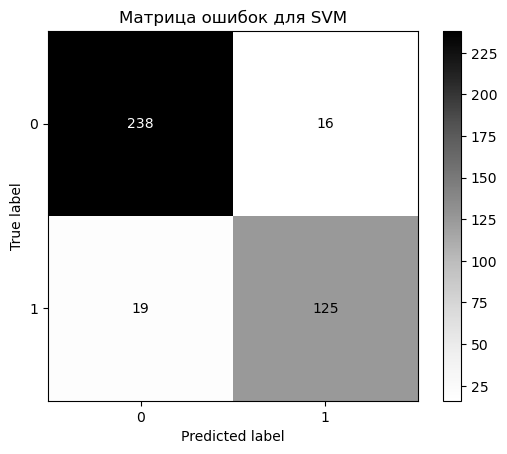

In [34]:
y_pred_svm = best_model_svm.predict(X_test_selected)

cm_svm = confusion_matrix(y_test, y_pred_svm)

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_model_svm.classes_)
disp_svm.plot(cmap='Greys', values_format='d')
plt.title("Матрица ошибок для SVM")
plt.show()

# Дополнительная оценка качества модели

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


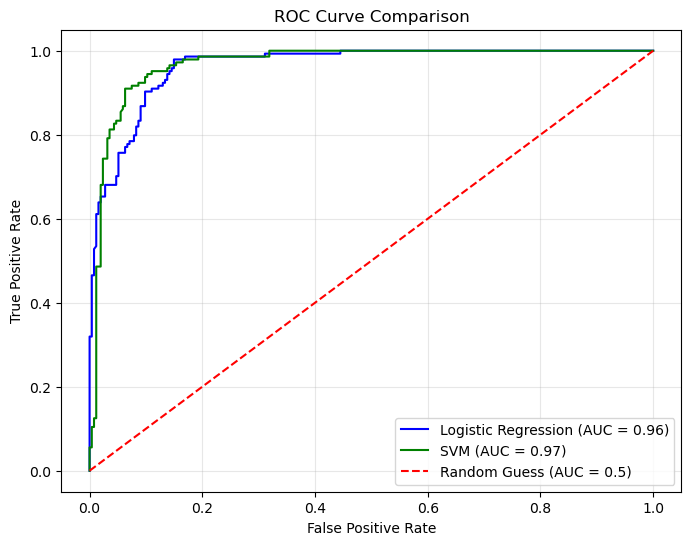

In [36]:
y_pred_proba_logreg = best_model.predict_proba(X_test_selected)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

y_pred_proba_svm = best_model_svm.predict_proba(X_test_selected)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})', color='blue')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)', color='red')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

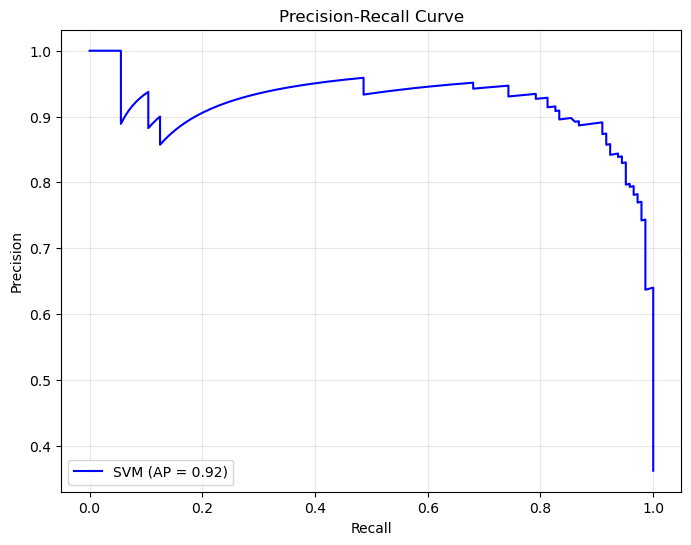

In [37]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_svm)
avg_precision = average_precision_score(y_test, y_pred_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'SVM (AP = {avg_precision:.2f})', color='blue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

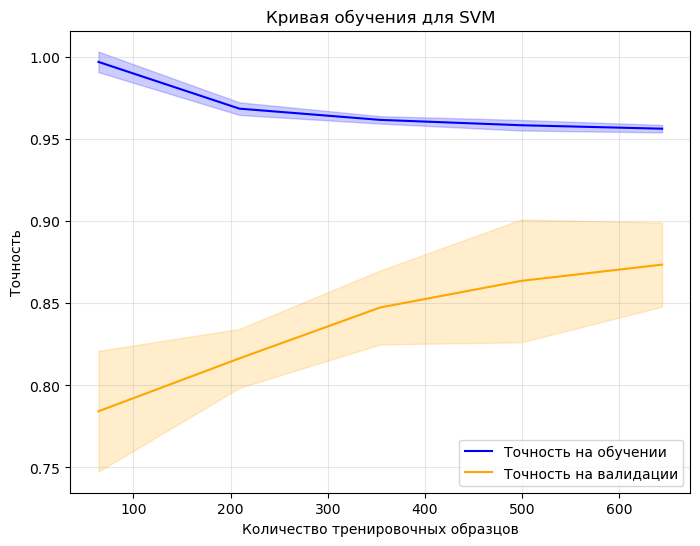

In [38]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model_svm, X_train_selected, y_train, cv=5, scoring='accuracy', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Точность на обучении', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_mean, label='Точность на валидации', color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
plt.title('Кривая обучения для SVM')
plt.xlabel('Количество тренировочных образцов')
plt.ylabel('Точность')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

**Я, у которой в массиве X показатель, по которому построенная целевая, получила результат оценки модели 100% качество:**

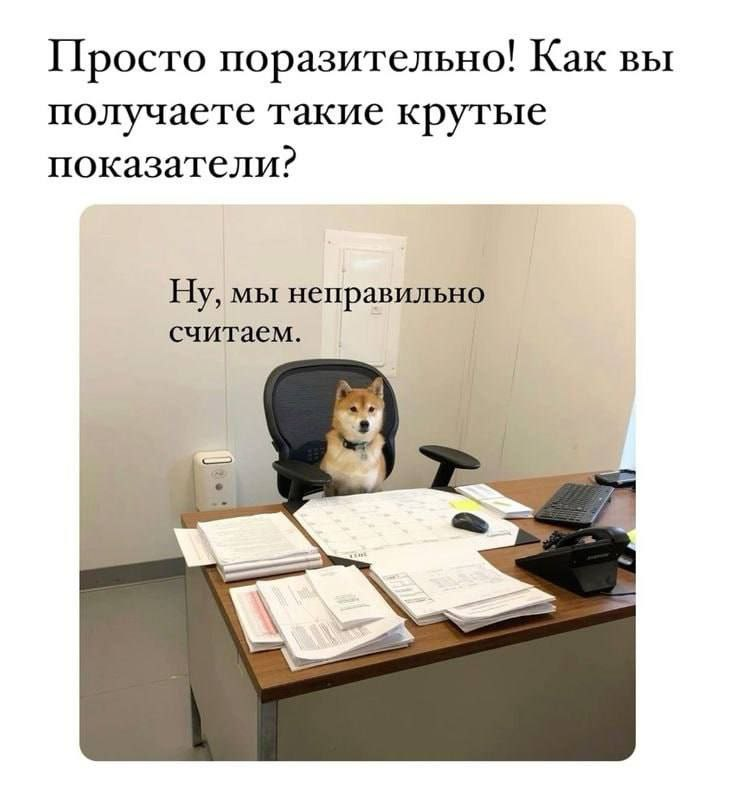